In [12]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import hsv_to_rgb
import numpy as np
import math
from PIL import Image
import cv2
import os, glob
from sklearn.linear_model import LinearRegression
%matplotlib inline
frame_avg = 5
right_coeffs_array = np.zeros((frame_avg,2))
left_coeffs_array = np.zeros((frame_avg,2))


In [13]:
# Defining the region of interest (clearing the information that we don't need)
def region_of_interest(updated_img):
    mask = np.zeros_like(updated_img)   
    ysize = updated_img.shape[0]
    xsize = updated_img.shape[1]

    vertices = np.array([(50, ysize),
                (xsize-50, ysize), 
                (xsize//2+50, ysize//2+50),
                (xsize//2-50, ysize//2+50)], dtype=np.int32)

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    
    cv2.fillPoly(mask, np.array([vertices], dtype=np.int32), (255,255,255))
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(updated_img, mask)
    return (masked_image)

In [16]:
# All the image processing takes place under this function

def process_images(image):
    
    base_img = image
    
    
    # TRY TO USE HSV TO CONVERT THE IMAGES LATER FOR BETTER DIFFERENTIATION
    right_lines = []
    left_lines = []
    right = []
    left = []
    ysize = base_img.shape[0]
    xsize = base_img.shape[1]
    white_upper_thld = (255,255,255)
    white_lower_thld = (220,220,215)
    yellow_upper_thld = (255,255,120)
    yellow_lower_thld = (130,130,0)

# Extracting yellow and white colors separately
    mask_yellow = cv2.inRange(base_img, yellow_lower_thld, yellow_upper_thld)
    mask_white = cv2.inRange(base_img, white_lower_thld, white_upper_thld)

    mask = cv2.bitwise_or(mask_white,mask_yellow)

# Masking everything except yellow and white colors from the image
    filtered_image = cv2.bitwise_and(base_img, base_img, mask = mask)

# Defining the region of interest    
    filtered_img_after_ROI = region_of_interest(filtered_image)
    #plt.imshow(filtered_img_after_ROI)

# Convert image to graysale 
    gray_filtered_img = cv2.cvtColor(filtered_img_after_ROI, cv2.COLOR_RGB2GRAY)
    #plt.imshow(gray_filtered_img,cmap='gray')

# Applying Gaussian Blur
    kernel_size = 7
    blur_gray = cv2.GaussianBlur(gray_filtered_img,(kernel_size, kernel_size), 0)
    #plt.imshow(blur_gray, cmap='gray')

#Defining thresholds for Canny Filter
    low_threshold = 100 #1
    high_threshold = 200 #50
    canny_images = cv2.Canny(blur_gray, low_threshold, high_threshold)
    #plt.imshow(canny_images, cmap='gray')


# HOUGH transform!

    rho = 1
    theta = np.pi/180
    threshold = 8 #8 works
    min_line_length = 7
    max_line_gap = 2 #2 works 
    line_image = np.zeros_like(base_img)

    lines = cv2.HoughLinesP(canny_images, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    
#Extracting left lane and right lane coordinates

    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            intercept = y1-(slope*x1)
            length = math.sqrt((y2-y1)**2+(x2-x1)**2)
            
            #if slope of a hough line is greater than 0.3 then it will be a right lane
            if slope>0.3:# and slope <0.6:
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
                right_lines.append(line)

            #if slope of a hough line is less than -0.3 then it will be a left lane
            elif slope<-0.3:# and slope >-0.6:
                cv2.line(line_image,(x1,y1),(x2,y2),(0,255,0),5)
                left_lines.append(line)


    # display images after HOUGH transform
    #plt.imshow(cv2.addWeighted(canny_images,1,line_image,.5,0))
    #plt.imshow(cv2.addWeighted(base_img,1,line_image,.5,0))
    print_hough_line = cv2.addWeighted(base_img,1,line_image,.5,0)

    right_lines = (np.array(right_lines))
    left_lines = (np.array(left_lines))
    
    # combining all the X and Y coordinates of right lane and converting array to list
    right_x_coord = list(map(int,np.concatenate([right_lines[:,:,0],right_lines[:,:,2]])))
    right_y_coord = list(map(int,np.concatenate([right_lines[:,:,1],right_lines[:,:,3]])))
    
    # Combining all the X and Y coordinates of left lane and converting array to list
    left_x_coord = list(map(int,np.concatenate([left_lines[:,:,0],left_lines[:,:,2]])))
    left_y_coord = list(map(int,np.concatenate([left_lines[:,:,1],left_lines[:,:,3]])))


# Finding polynomial fit
    order_of_polynomial = 1
    temp_right_coeff = np.polyfit(right_y_coord,right_x_coord,order_of_polynomial)
    temp_left_coeff = np.polyfit(left_y_coord,left_x_coord,order_of_polynomial)
    
    global right_coeffs_array
    right_coeffs_array = np.append(right_coeffs_array,[temp_right_coeff],axis=0)
    right_coeffs_array = np.delete(right_coeffs_array,(0),axis=0)
    
    global left_coeffs_array
    left_coeffs_array = np.append(left_coeffs_array,[temp_left_coeff],axis=0)
    left_coeffs_array = np.delete(left_coeffs_array,(0),axis=0)
    
    """
    if np.all(right_coeffs_array): 
        right_coeff = np.mean(right_coeffs_array, axis=0)
    else:
        right_coeff = temp_right_coeff
    
    if np.all(left_coeffs_array):
        left_coeff = np.mean(left_coeffs_array, axis=0)
    else:
        left_coeff = temp_left_coeff
    """
    left_coeff = temp_left_coeff
    right_coeff = temp_right_coeff
    
    p_right = np.poly1d(right_coeff)
    p_left = np.poly1d(left_coeff)
    yp = np.linspace(ysize*0.65,ysize, 100)

    #rolling average of slopes
    
    
    
    right = np.transpose(np.array([p_right(yp),yp], np.int32))
    left = np.transpose(np.array([p_left(yp),yp], np.int32))
    final_lines = np.zeros_like(base_img)

# Plotting the lines on the image
    right_lane_poly = cv2.polylines(final_lines,np.int32([right]),0,(255,0,0),7)
    left_lane_poly = cv2.polylines(final_lines,np.int32([left]),0,(0,255,0),7)
    
    #plt.imshow(background_image)
    image_with_lanes = cv2.addWeighted(base_img,1,right_lane_poly,.8,0)
    image_with_lanes = cv2.addWeighted(base_img,1,left_lane_poly,.8,0)
    
    #return print_hough_line
    #return [image_with_lanes, right_coeff, left_coeff]
    return image_with_lanes

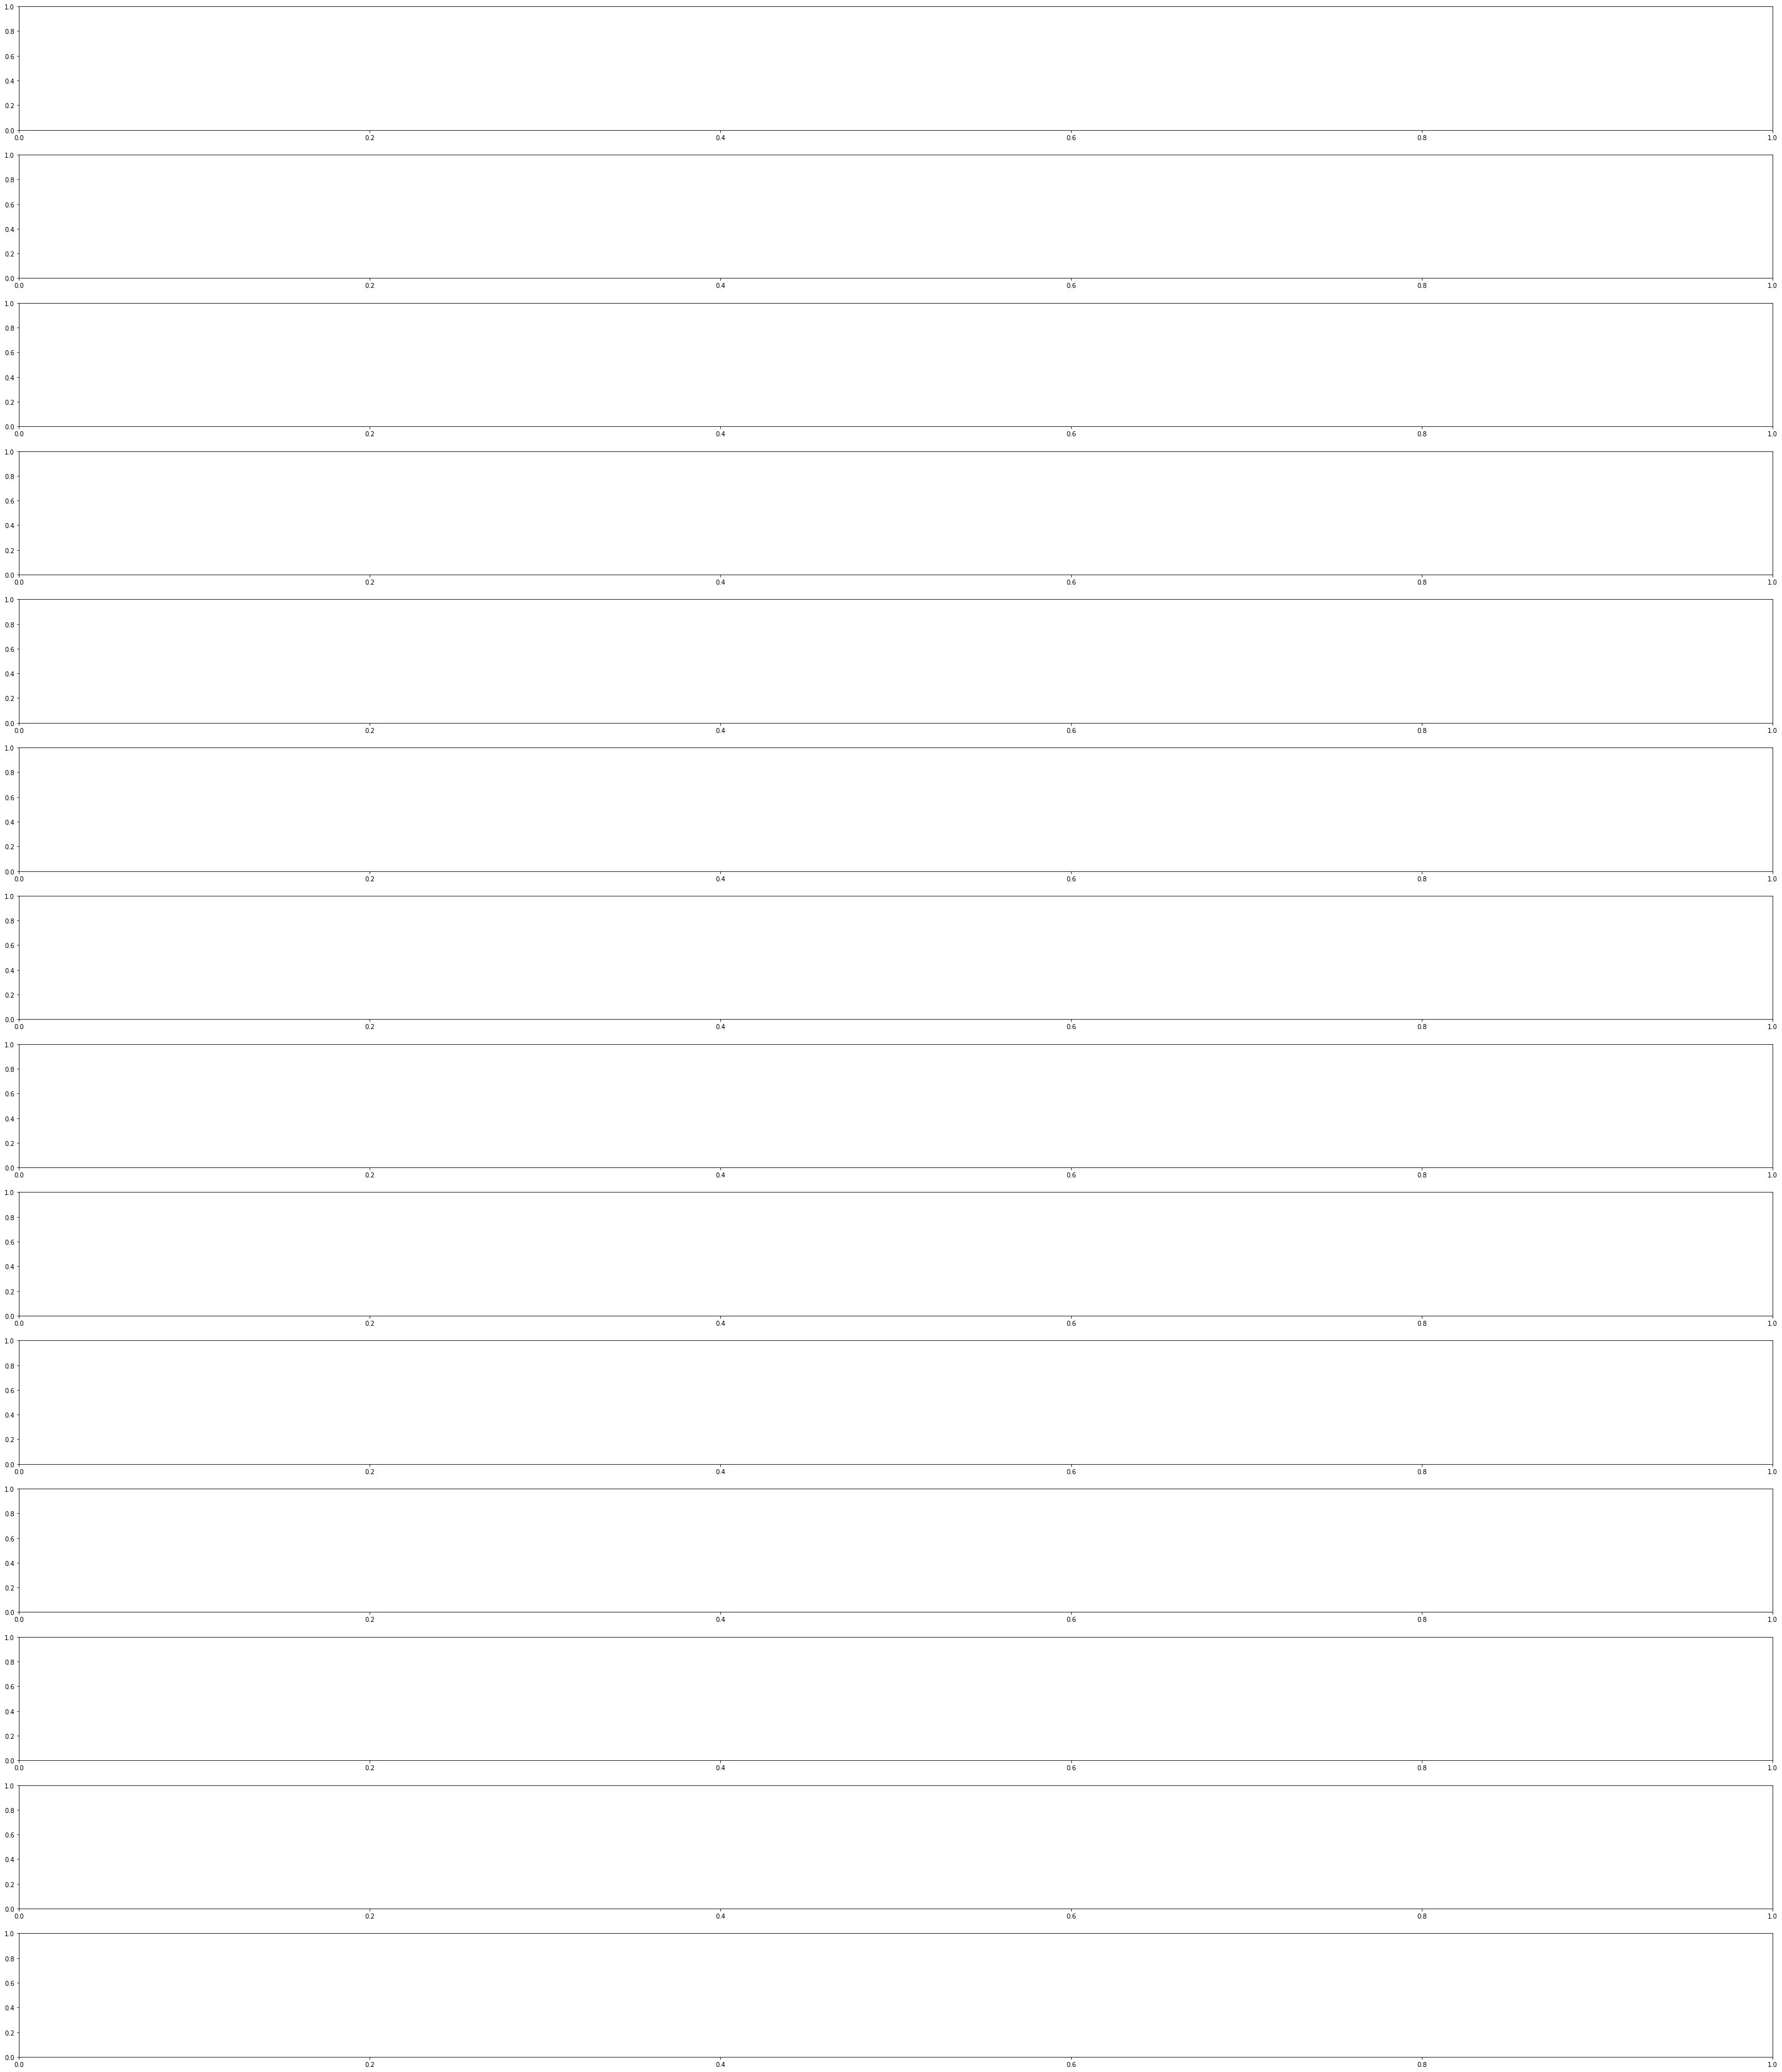

In [17]:
#reading in all images
all_images = [cv2.imread(file) for file in glob.glob('CarND-LaneLines-P1/test_images/originals/*.jpg')]
plt.figure(figsize=(50,60))
    
for index,img_value in enumerate(all_images):
    plt.subplot(len(all_images),1,index+1)
    image_for_processing = cv2.cvtColor(img_value, cv2.COLOR_BGR2RGB)
    image_with_lanes_final = process_images(image_for_processing)
    
    #plt.imshow(image_with_lanes_final)
    image_with_lanes_final = cv2.cvtColor(image_with_lanes_final, cv2.COLOR_RGB2BGR)
    cv2.imwrite('CarND-LaneLines-P1/test_images/Final processed images/'+str(index+1)+'.jpg',image_with_lanes_final)
    

In [7]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
white_output = 'CarND-LaneLines-P1/test_videos_output/challenge.mp4' #solidWhiteRight #solidYellowLeft

clip1 = VideoFileClip("CarND-LaneLines-P1/test_videos/challenge.mp4")#.subclip(5,7)#challenge

white_clip = clip1.fl_image(process_images) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video CarND-LaneLines-P1/test_videos_output/challenge.mp4
[MoviePy] Writing video CarND-LaneLines-P1/test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:18<00:00, 13.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: CarND-LaneLines-P1/test_videos_output/challenge.mp4 

Wall time: 20.6 s
